<div style="background-color:white; text-align:center; font-family:Arial, Helvetica, sans-serif; padding:50px;">
  <!-- Tytuł -->
  <div style="color:#993520; font-size:60px; font-weight:bold; margin-bottom:20px;">
    MACHINE LEARNING 2 - REGRESSION PROJECT
  </div>

  <!-- Podtytuł -->
  <div style="color:#993520; font-size:35px; margin-bottom:40px;">
    Used Cars Price Prediction
  </div>

  <!-- Autor -->
  <div style="color:black; font-size:30px; margin-bottom:10px;">
    Aleksandra Dobosz & Wojciech Hrycenko
  </div>

  <!-- Data / semestr -->
  <div style="color:black; font-size:30px; margin-bottom:20px;">
    Autumn 2025
  </div>

### 0. Setup and Imports
Importing necessary libraries and setting global configurations.
Ensures reproducibility and cleaner output presentation.

In [1]:
# --- 1. Core Data Science Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 2. Machine Learning (Scikit-Learn & XGBoost) ---
# Preprocessing & Split
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- 3. Utilities ---
import warnings
import joblib  # For saving the model

# --- 4. Global Configuration (For Reproducibility & Style) ---
# Suppress annoying warnings for a cleaner report (Presentation score)
warnings.filterwarnings('ignore')

# Set global random seed for reproducibility (CRITICAL for 'Reproducibility' criterion)
SEED = 42
np.random.seed(SEED)

# Visualization settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)  # Show all columns when printing DFs

print("Libraries imported successfully. Random seed set to 42.")

Libraries imported successfully. Random seed set to 42.


## 1. Introduction and Project Overview
In this project, we aim to develop a machine learning model to predict the prices of used cars based on various features. Accurate price prediction can assist buyers and sellers in making informed decisions in the used car market.

### 1.1 About Dataset
Craigslist is the world's largest collection of used vehicles for sale, yet it's very difficult to collect all of them in the same place. I built a scraper for a school project and expanded upon it later to create this dataset which includes every used vehicle entry within the United States on Craigslist. This data is scraped every few months, it contains most all relevant information that Craigslist provides on car sales including columns like price, condition, manufacturer, latitude/longitude, and 18 other categories.

### 1.2 Project Objectives
* **Data Cleaning:** Handle missing values and remove outliers (e.g., unrealistic prices).
* **Feature Engineering:** Extract meaningful features from existing data (e.g., vehicle age, luxury status).
* **Modeling:** Implement and compare multiple regression algorithms (Linear, Random Forest, XGBoost, Neural Networks).
* **Optimization:** Apply hyperparameter tuning and ensembling to achieve the best performance.

## 2. Data Quality Assessment
Before cleaning, we must understand the "health" of the data. We will analyze:
1.  **Missing Values:** Identifying columns with excessive gaps (e.g., >40% missing).
2.  **Cardinality:** Checking unique values to identify ID columns (useless for regression) or constant columns.
3.  **Duplicates:** Checking for repeated entries.

In [ ]:
def load_and_audit_data(filepath):
    """
    Loads the dataset and prints a comprehensive quality report.
    Does NOT modify the data yet.
    """
    try:
        print(f"Loading data from '{filepath}'...")
        df = pd.read_csv(filepath)
        
        # 1. Basic Info
        print(f"--- Data Shape: {df.shape} (Rows, Cols) ---")
        
        # 2. Duplicate Check
        duplicates = df.duplicated().sum()
        print(f"--- Duplicates Found: {duplicates} ---")
        
        # 3. Missing Values Analysis
        missing = df.isna().sum()
        missing_pct = (missing / len(df)) * 100
        
        # Create a clean report table
        report = pd.DataFrame({
            'Missing Count': missing, 
            'Missing %': missing_pct
        })
        
        # Filter to show only columns with missing values (sorted)
        missing_report = report[report['Missing %'] > 0].sort_values(by='Missing %', ascending=False)
        
        print("\n--- Top 10 Columns with Missing Values ---")
        display(missing_report.head(30))
        
        return df
    
    except FileNotFoundError:
        print(f"Error: File '{filepath}' not found. Please check the path.")
        return None

# Execution
df_raw = load_and_audit_data('vehicles.csv')

Loading data from 'vehicles.csv'...
--- Data Shape: (426880, 26) (Rows, Cols) ---
--- Duplicates Found: 0 ---

--- Top 10 Columns with Missing Values ---


,Missing Count,Missing %
county,426880,100.000000
size,306361,71.767476
cylinders,177678,41.622470
condition,174104,40.785232
VIN,161042,37.725356
drive,130567,30.586347
paint_color,130203,30.501078
type,92858,21.752717
manufacturer,17646,4.133714
title_status,8242,1.930753


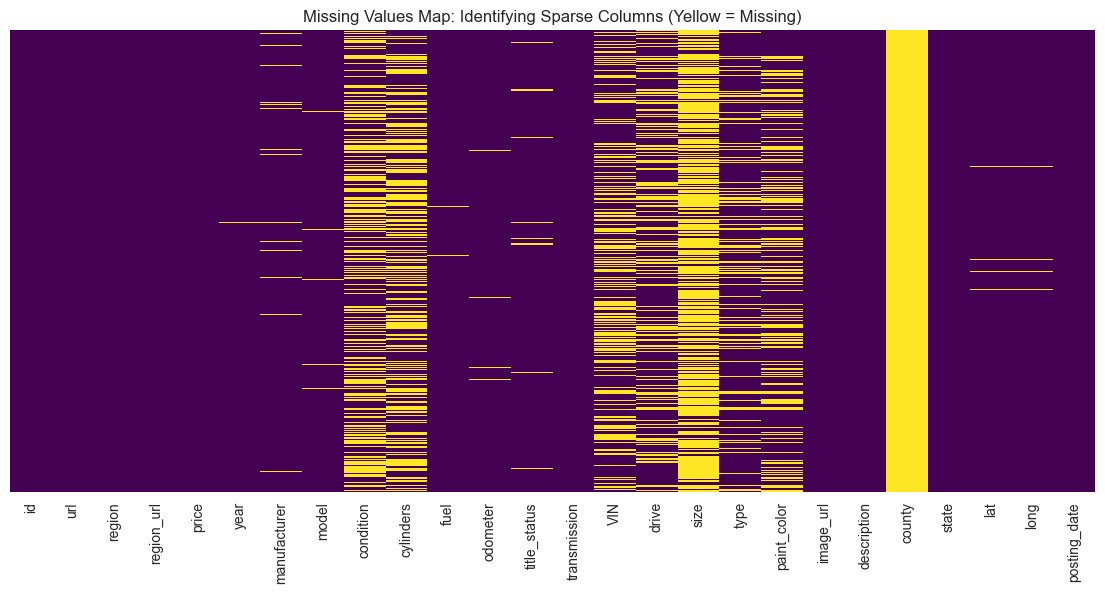

In [3]:
plt.figure(figsize=(14, 6))
# Heatmap of missing values: Yellow lines indicate missing data
sns.heatmap(df_raw.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Missing Values Map: Identifying Sparse Columns (Yellow = Missing)')
plt.show()

### 2.1 Cleaning Decision Logic
Based on the Quality Assessment Report and Heatmap, we apply the following cleaning strategy:

1.  **Drop High-Missing Columns:**
    * `county`: **100% missing**. Completely empty feature.
    * `size`: **~71.8% missing**. Imputing this would introduce significant noise.
2.  **Drop Technical/ID Columns:**
    * `id`, `url`, `image_url`, `region_url`: Metadata not relevant for price prediction.
    * `VIN`: Unique identifier (~37% missing). While potentially useful for API decoding, it is too sparse and high-cardinality for this direct regression model.
3.  **Handle Duplicates:** Although 0 duplicates were found initially, we retain the deduplication step for pipeline robustness.
4.  **Row-wise Dropping:**
    * We remove rows where the **Target Variable (`price`)** is missing.
    * We remove rows where critical predictors (`year`, `odometer`) are missing, as these are fundamental to vehicle valuation.

In [12]:
def clean_initial_data(df):
    """
    Applies cleaning logic derived from the Quality Assessment.
    Drops irrelevant columns and rows with missing critical data.
    """
    df_clean = df.copy()
    
    # 1. Drop columns identified in the audit
    cols_to_drop = [
        'id', 'url', 'region_url', 'image_url', 'size', 
        'county', 'VIN', 'lat', 'long', 'posting_date', 'description'
    ]
    
    # Drop only columns that actually exist
    existing_drop = [c for c in cols_to_drop if c in df_clean.columns]
    df_clean = df_clean.drop(columns=existing_drop)
    
    # 2. Drop Duplicates
    df_clean = df_clean.drop_duplicates()
    
    # 3. Handle Critical Rows (Price, Year, Odometer)
    initial_rows = len(df_clean)
    df_clean = df_clean.dropna(subset=['price', 'year', 'odometer'])
    dropped_rows = initial_rows - len(df_clean)
    
    print(f"Cleaning complete. Dropped {dropped_rows} rows with missing critical info.")
    print(f"New Data Shape: {df_clean.shape}")
    
    return df_clean

# Execution
df_clean_step1 = clean_initial_data(df_raw)

Cleaning complete. Dropped 4374 rows with missing critical info.
New Data Shape: (366015, 15)


### 2.2 Missing Values Imputation
Instead of dropping rows with missing categorical data (e.g., `fuel`, `transmission`), we impute them with a placeholder `'unknown'`.
**Reasoning:**
1.  **Data Preservation:** Dropping these rows would discard valid price/year/mileage data.
2.  **Bias Reduction:** Vehicles with missing descriptions might be older or cheaper; removing them could bias the model towards higher-end listings.

In [13]:
def impute_missing_values(df):
    """
    Fills missing categorical values with 'unknown' to preserve data volume.
    """
    df_filled = df.copy()
    
    # Categorical columns to fill
    # We prioritize keeping the row even if details are missing
    cat_cols = [
        'manufacturer', 'model', 'condition', 'cylinders', 
        'fuel', 'title_status', 'transmission', 'drive', 'type', 'paint_color'
    ]
    
    # Fill only existing columns
    cols_to_fill = [c for c in cat_cols if c in df_filled.columns]
    
    for col in cols_to_fill:
        df_filled[col] = df_filled[col].fillna('unknown')
            
    # Verification
    remaining_missing = df_filled.isna().sum().sum()
    print(f"Imputation complete. Remaining missing values: {remaining_missing}")
    
    return df_filled

# Execution
df_imputed = impute_missing_values(df_clean_step1)

Imputation complete. Remaining missing values: 0


## 3. Outlier Detection and Removal
Craigslist data often contains unrealistic values due to user error or spam (e.g., price $0, price $12345678, year 2999).

**Filtering Logic:**
* **Price:** Keep \$500 - \$150,000 (Removes junk cars and super-luxury outliers/errors).
* **Year:** Keep > 1990 (Focus on relevant modern market).
* **Odometer:** Keep < 400,000 miles (Removes likely data entry errors).

Outlier Removal Summary:
  Original: 366015
  Retained: 322976
  Dropped:  43039 (11.76%)


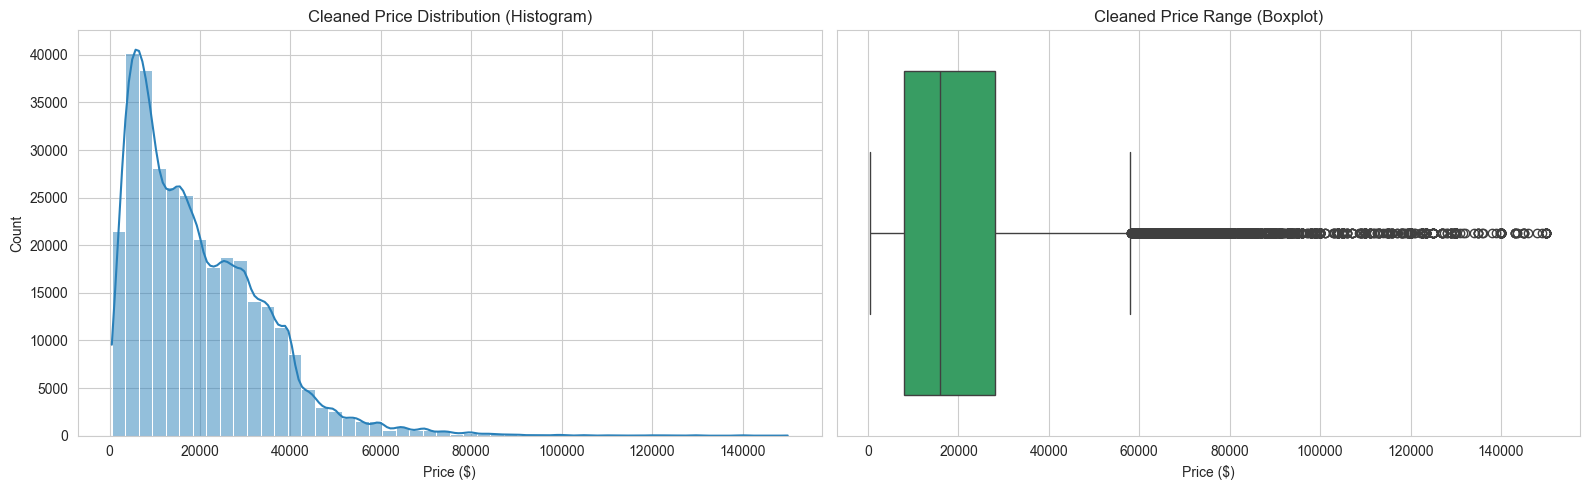

In [14]:
# --- MODULE 3: OUTLIER REMOVAL & VISUALIZATION ---

def remove_outliers(df, price_min=500, price_max=150000, year_min=1990, odo_max=400000):
    """
    Filters out rows based on domain-knowledge thresholds to improve model stability.
    Returns: df_final_clean
    """
    initial_count = len(df)
    
    # Define valid range mask
    mask = (
        (df['price'] >= price_min) & 
        (df['price'] <= price_max) &
        (df['year'] >= year_min) &
        (df['year'] <= 2025) &      # Safety check for future years
        (df['odometer'] >= 0) & 
        (df['odometer'] <= odo_max)
    )
    
    df_clean = df[mask].copy()
    
    # Final Polish: Drop any remaining stray NaNs (e.g., from impute step residue)
    df_clean = df_clean.dropna()
    
    dropped = initial_count - len(df_clean)
    
    print(f"Outlier Removal Summary:")
    print(f"  Original: {initial_count}")
    print(f"  Retained: {len(df_clean)}")
    print(f"  Dropped:  {dropped} ({(dropped/initial_count)*100:.2f}%)")
    
    return df_clean

def plot_clean_distribution(df):
    """
    Visualizes the Target Variable (Price) to verify cleaning quality.
    """
    fig, ax = plt.subplots(1, 2, figsize=(16, 5))
    
    # Histogram
    sns.histplot(df['price'], bins=50, kde=True, ax=ax[0], color='#2980b9')
    ax[0].set_title('Cleaned Price Distribution (Histogram)')
    ax[0].set_xlabel('Price ($)')
    
    # Boxplot
    sns.boxplot(x=df['price'], ax=ax[1], color='#27ae60')
    ax[1].set_title('Cleaned Price Range (Boxplot)')
    ax[1].set_xlabel('Price ($)')
    
    plt.tight_layout()
    plt.show()

# Execution
# This creates the crucial 'df_final_clean' variable needed for the next step
df_final_clean = remove_outliers(df_imputed)
plot_clean_distribution(df_final_clean)

In [15]:
# Final Polish: Drop any remaining stray NaNs (e.g., 2 rows)
df_final_clean = df_final_clean.dropna()
print(f"Final Data Check: {df_final_clean.isna().sum().sum()} missing values.")
print(f"Ready for Feature Engineering. Shape: {df_final_clean.shape}")

Final Data Check: 0 missing values.
Ready for Feature Engineering. Shape: (322976, 15)


In [8]:
df_final_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 342861 entries, 27 to 426879
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        342861 non-null  object 
 1   price         342861 non-null  int64  
 2   year          342861 non-null  float64
 3   manufacturer  342861 non-null  object 
 4   model         342861 non-null  object 
 5   condition     342861 non-null  object 
 6   cylinders     342861 non-null  object 
 7   fuel          342861 non-null  object 
 8   odometer      342861 non-null  float64
 9   title_status  342861 non-null  object 
 10  transmission  342861 non-null  object 
 11  drive         342861 non-null  object 
 12  type          342861 non-null  object 
 13  paint_color   342861 non-null  object 
 14  description   342861 non-null  object 
 15  state         342861 non-null  object 
dtypes: float64(2), int64(1), object(13)
memory usage: 44.5+ MB


## 4. Exploratory Data Analysis (EDA)

### 4.1 Target Variable Distribution
* **Goal:** Visualize the distribution of car prices to identify skewness and potential outliers.
* **Interpretation:** A strong right skew (long tail to the right) is expected in financial data. This confirms whether log-transformation is necessary for modeling.

### 4.2 Numerical Correlation Matrix
* **Goal:** Identify linear relationships between numerical features and the target variable (`price`).
* **Interpretation:**
    * **Red:** Positive correlation (e.g., `year` vs. `price`).
    * **Blue:** Negative correlation (e.g., `odometer` vs. `price`).

### 4.3 Depreciation Curve (Price vs. Odometer)
* **Goal:** Analyze how mileage impacts the vehicle's value.
* **Interpretation:** Shows the inverse relationship between usage and price. The density of points near the axes reveals the most common market segments.

### 4.4 Brand Valuation (Top 10 Manufacturers)
* **Goal:** Compare the price ranges of the most popular brands.
* **Interpretation:** The boxplot shows the median price (center line) and spread for each brand, helping separate budget manufacturers from premium ones.

### 4.5 Price Trend Over Time
* **Goal:** Visualize the depreciation rate based on the model year.
* **Interpretation:** Shows the average price decline as cars get older. Steep slopes indicate years where depreciation is most rapid.

### 4.6 Value by Vehicle Class
* **Goal:** Rank vehicle types (e.g., SUV, Sedan, Pickup) by their average market value.
* **Interpretation:** Identifies which categories command the highest premiums (typically Trucks/Pickups) versus economy segments.

### 4.7 Impact of Fuel Type
* **Goal:** Analyze price differences based on the engine's fuel type.
* **Interpretation:** Reveals if certain fuel types (like Diesel or Electric) retain higher median values compared to standard Gas vehicles.

### 4.8 Density Map (Hexbin Plot)
* **Goal:** Handle overplotting in large datasets to see where the majority of data points lie.
* **Interpretation:** Darker hexagons represent a higher concentration of cars. This provides a clearer view of the "typical" car price/mileage ratio than a standard scatter plot.

### 4.9 Cylinders vs. Price (Violin Plot)
* **Goal:** Visualize the probability density of prices across different engine sizes.
* **Interpretation:**
    * **Width:** Wider sections indicate a higher frequency of cars at that price point.
    * **Shape:** Allows us to see if specific engine configurations (e.g., V8) have a wider price variance than others.

### 4.10 Multivariate Interaction: Year, Price, and Drive
* **Goal:** Analyze how drivetrain configuration (`4wd`, `fwd`, `rwd`) affects value retention over time.
* **Interpretation:** Helps determine if, for example, 4WD vehicles maintain higher prices in older model years compared to FWD vehicles.

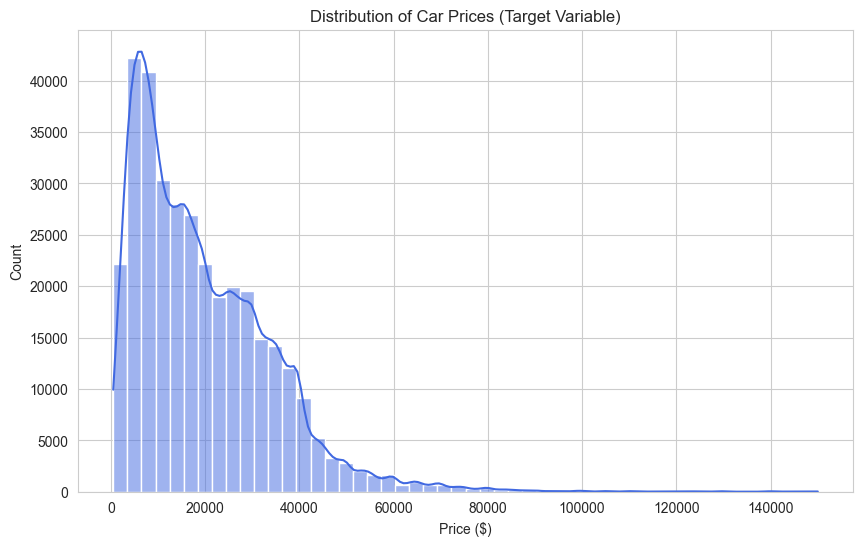

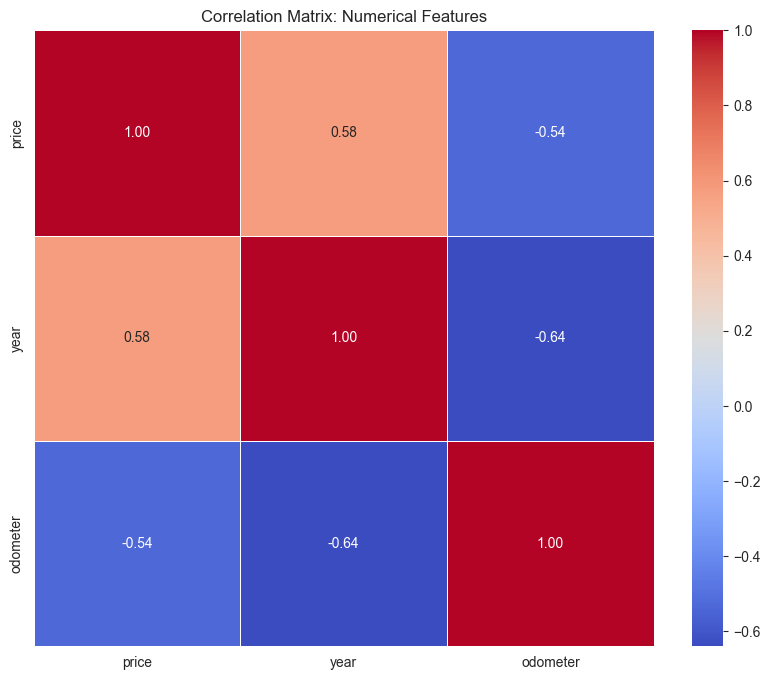

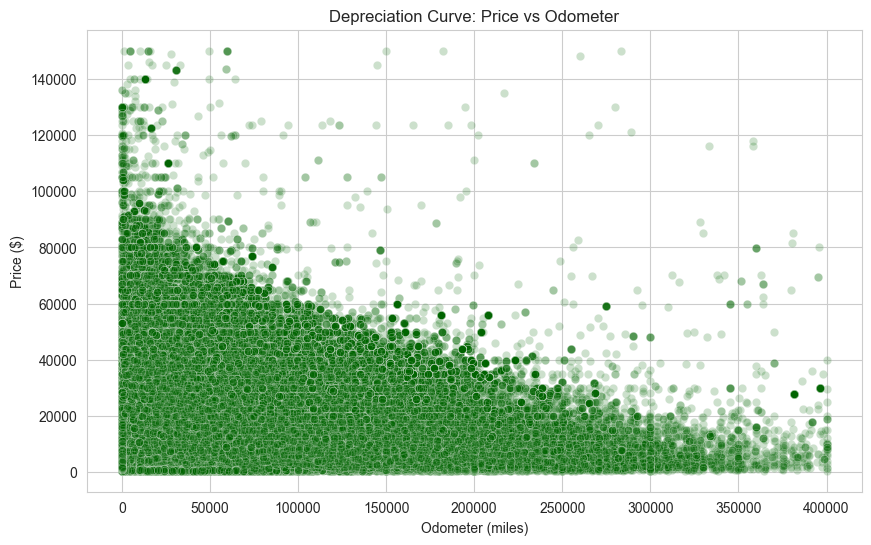

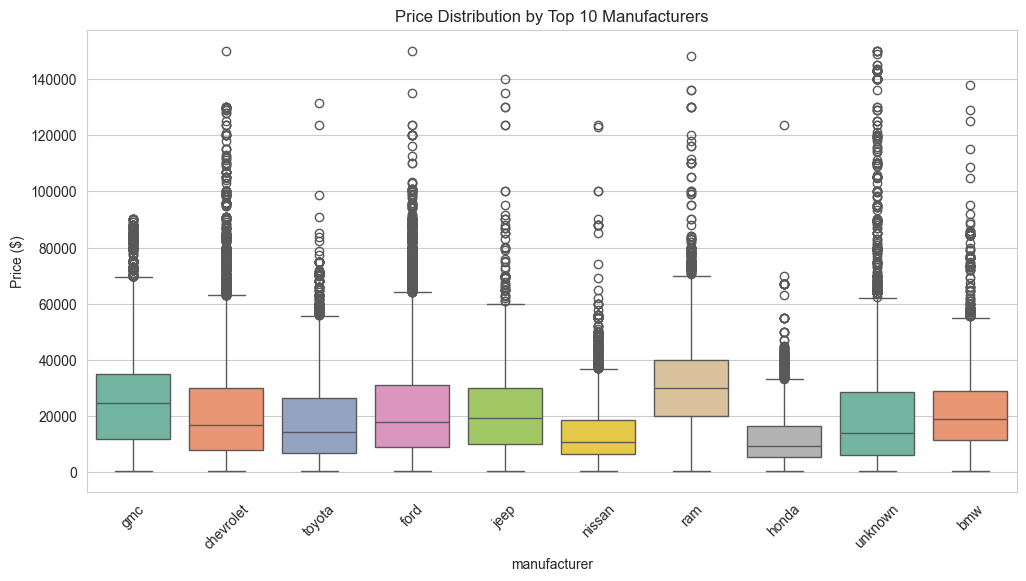

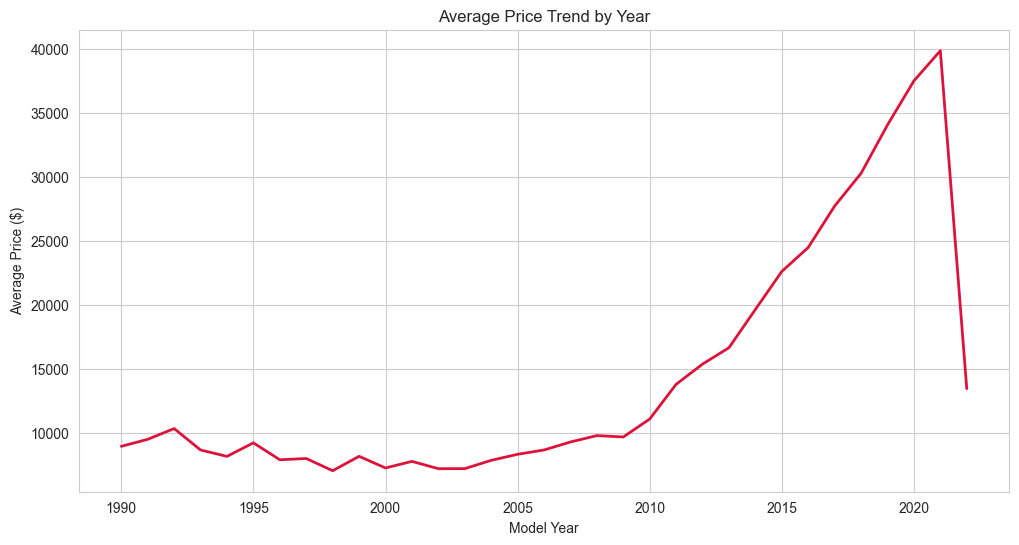

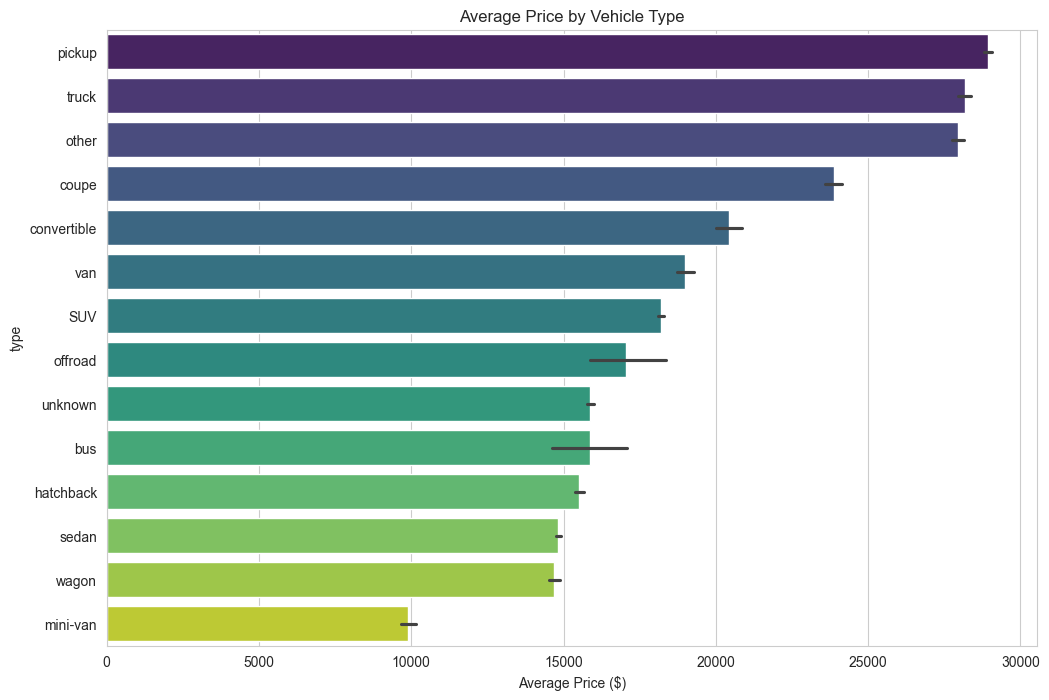

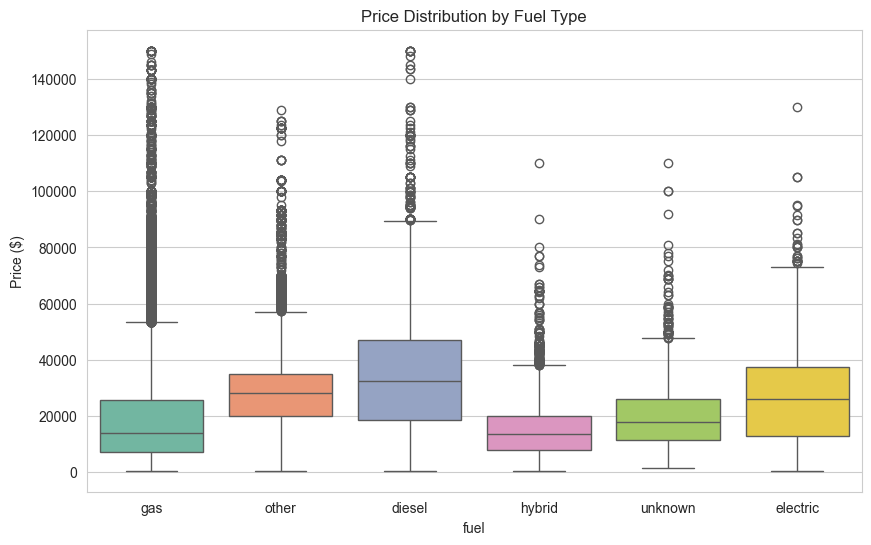

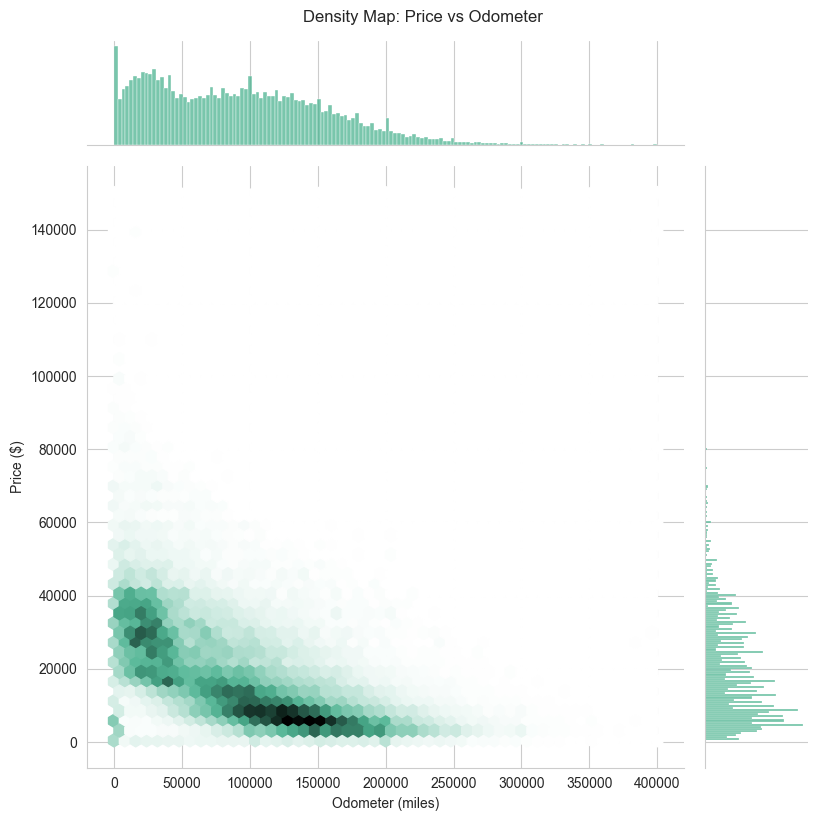

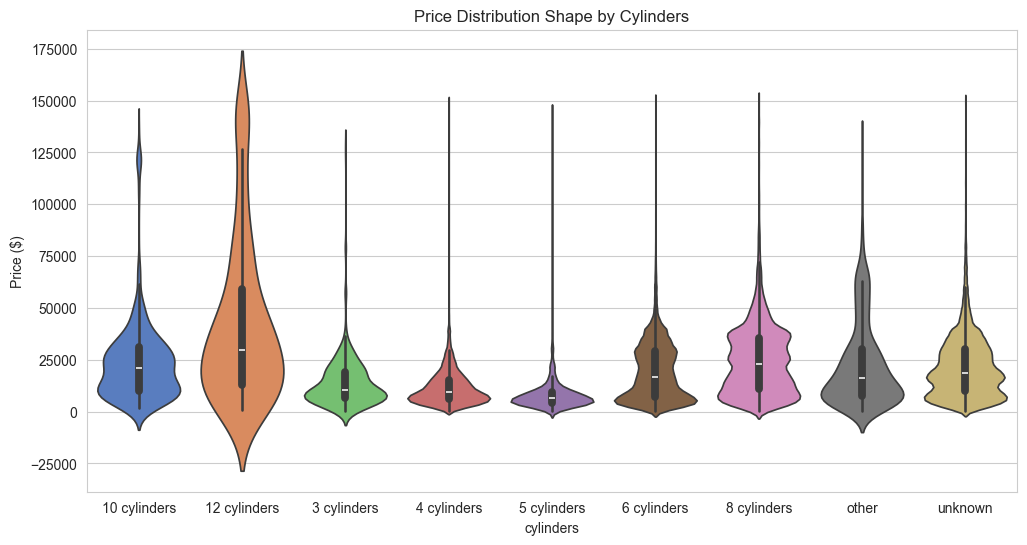

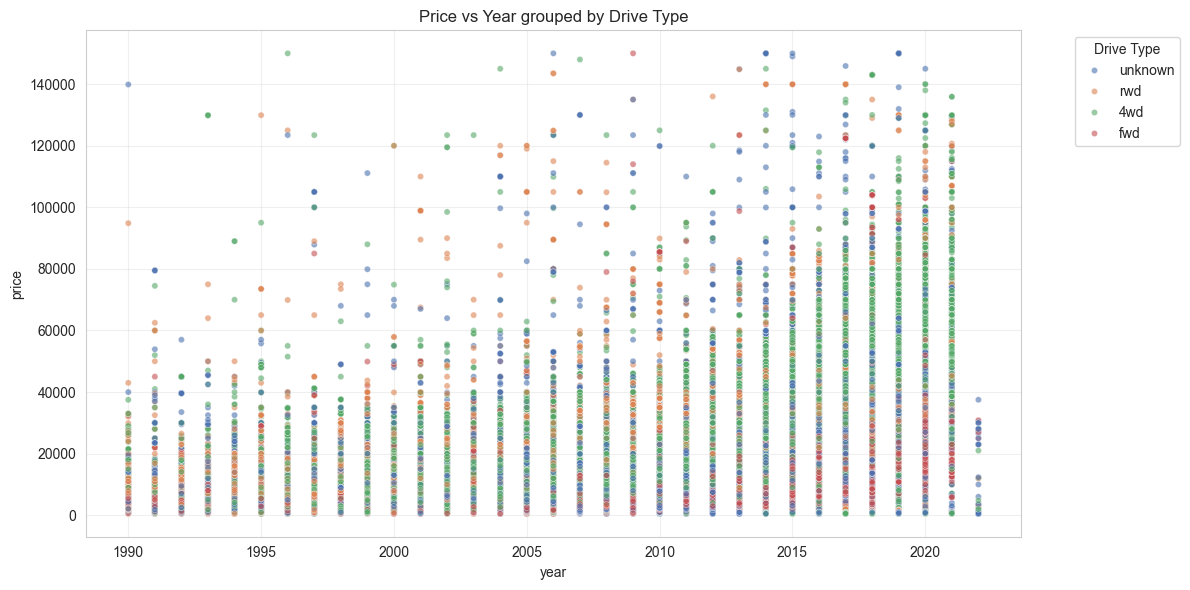

In [11]:
# Set global style
sns.set_style("whitegrid")
# Use a consistent DataFrame variable
df_final_clean = df_final_clean.copy() 

# --- PART 1: Basic Distributions & Correlations ---

# 1. Distribution of Price
plt.figure(figsize=(10, 6))
sns.histplot(df_final_clean['price'], bins=50, kde=True, color='royalblue')
plt.title('Distribution of Car Prices (Target Variable)')
plt.xlabel('Price ($)')
plt.show()

# 2. Correlation Heatmap
plt.figure(figsize=(10, 8))
corr_matrix = df_final_clean.select_dtypes(include=['number']).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix: Numerical Features')
plt.show()

# 3. Price vs Odometer (Scatter)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='odometer', y='price', data=df_final_clean, alpha=0.2, color='darkgreen')
plt.title('Depreciation Curve: Price vs Odometer')
plt.xlabel('Odometer (miles)')
plt.ylabel('Price ($)')
plt.show()

# 4. Top 10 Manufacturers Analysis
plt.figure(figsize=(12, 6))
top_manufacturers = df_final_clean['manufacturer'].value_counts().head(10).index
df_top = df_final_clean[df_final_clean['manufacturer'].isin(top_manufacturers)]

sns.boxplot(x='manufacturer', y='price', data=df_top, palette="Set2")
plt.title('Price Distribution by Top 10 Manufacturers')
plt.xticks(rotation=45)
plt.ylabel('Price ($)')
plt.show()

# --- PART 2: Advanced Categorical & Temporal Analysis ---

# 5. Price Trend over Years
plt.figure(figsize=(12, 6))
sns.lineplot(x='year', y='price', data=df_final_clean, estimator='mean', errorbar=None, color='crimson', lw=2)
plt.title('Average Price Trend by Year')
plt.ylabel('Average Price ($)')
plt.xlabel('Model Year')
plt.show()

# 6. Average Price by Vehicle Type
plt.figure(figsize=(12, 8))
order_type = df_final_clean.groupby('type')['price'].mean().sort_values(ascending=False).index
sns.barplot(x='price', y='type', data=df_final_clean, order=order_type, palette='viridis')
plt.title('Average Price by Vehicle Type')
plt.xlabel('Average Price ($)')
plt.show()

# 7. Price by Fuel Type
plt.figure(figsize=(10, 6))
sns.boxplot(x='fuel', y='price', data=df_final_clean, palette='Set2')
plt.title('Price Distribution by Fuel Type')
plt.ylabel('Price ($)')
plt.show()

# --- PART 3: Multivariate & Density Analysis ---

# 8. Hexbin Density Plot
# Note: jointplot creates its own figure
g = sns.jointplot(x='odometer', y='price', data=df_final_clean, kind="hex", color="#4CB391", height=8)
g.fig.suptitle('Density Map: Price vs Odometer', y=1.02)
g.set_axis_labels('Odometer (miles)', 'Price ($)')
plt.show()

# 9. Violin Plot (Cylinders)
plt.figure(figsize=(12, 6))
# Ensure cylinders are sorted for visual consistency
try:
    order_cyl = sorted(df_final_clean['cylinders'].dropna().unique())
except:
    order_cyl = None # Fallback if sorting fails

sns.violinplot(x='cylinders', y='price', data=df_final_clean, order=order_cyl, palette='muted')
plt.title('Price Distribution Shape by Cylinders')
plt.ylabel('Price ($)')
plt.show()

# 10. Multivariate: Price vs Year by Drive
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x='year', 
    y='price', 
    data=df_final_clean, 
    hue='drive', 
    alpha=0.6, 
    palette='deep',
    s=20
)
plt.title('Price vs Year grouped by Drive Type')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Drive Type')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Feature Engineering and Preprocessing
We implement advanced feature extraction to capture non-linear relationships and ordinal data structures.

### 5.1 Engineered Features
1.  **`is_luxury`**: Binary flag for premium brands. Captures brand-specific depreciation curves.
2.  **`car_age`**: Vehicle age relative to 2025.
3.  **`wear_factor`**: Interaction (`car_age` * `odometer`). Represents cumulative stress on the vehicle.
4.  **`miles_per_year`**: Usage intensity. Calculated as `odometer / car_age`. High annual mileage negatively impacts value more than total mileage alone.
5.  **`cylinders_num`**: Parsed numerical value from the `cylinders` text field (e.g., "6 cylinders" -> 6). Allows the model to see the linear relationship between engine size and price.
6.  **`condition_rank`**: Ordinal mapping of the `condition` column (e.g., 'excellent' -> 4, 'fair' -> 1). This preserves the hierarchy of vehicle states.

### 5.2 Pipeline
* **Ordinal Encoding:** For `condition` and `cylinders`.
* **One-Hot Encoding:** For nominal categories (`fuel`, `drive`, `manufacturer`).
* **Scaling:** Standardization of all numerical features.

In [25]:
random_subset = df_final_clean.sample(n=50000)

In [26]:
# --- MODULE 4: ADVANCED FEATURE ENGINEERING PIPELINE ---

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import re

def parse_cylinders(text):
    """
    Extracts the integer number of cylinders from text like '6 cylinders'.
    Returns median (6) if unknown or 'other'.
    """
    if isinstance(text, str):
        # Look for digits in the string
        match = re.search(r'(\d+)', text)
        if match:
            return int(match.group(1))
    return 6 # Default median value for cars

def engineer_features(df):
    """
    Creates rich domain features including text parsing and ordinal mapping.
    """
    df_eng = df.copy()
    
    # 1. Luxury Flag
    luxury_brands = [
        'audi', 'bmw', 'cadillac', 'ferrari', 'infiniti', 'jaguar', 'land rover', 
        'lexus', 'lincoln', 'mercedes-benz', 'porsche', 'tesla', 'volvo', 
        'alfa-romeo', 'aston-martin', 'rover'
    ]
    df_eng['is_luxury'] = df_eng['manufacturer'].apply(lambda x: 1 if x in luxury_brands else 0)
    
    # 2. Car Age
    df_eng['car_age'] = 2025 - df_eng['year']
    
    # 3. Usage Intensity (Miles Per Year)
    # Avoid division by zero for new cars (age 0 -> age 1)
    safe_age = df_eng['car_age'].replace(0, 1)
    df_eng['miles_per_year'] = df_eng['odometer'] / safe_age
    
    # 4. Wear Factor
    df_eng['wear_factor'] = df_eng['car_age'] * df_eng['odometer']
    
    # 5. Parse Cylinders (Text to Int)
    df_eng['cylinders_num'] = df_eng['cylinders'].apply(parse_cylinders)
    
    # 6. Map Condition (Ordinal Encoding)
    # We map text to a 0-5 scale manually
    condition_map = {
        'new': 5,
        'like new': 4,
        'excellent': 3,
        'good': 2,
        'fair': 1,
        'salvage': 0,
        'unknown': 2  # Assume 'good' if unknown
    }
    df_eng['condition_rank'] = df_eng['condition'].map(condition_map)
    
    return df_eng

def preprocess_pipeline(df, target_col='price'):
    print("Starting Advanced Preprocessing...")
    
    # 1. Engineering
    df_eng = engineer_features(df)
    
    # 2. Selection
    # Drop columns that we have already engineered into better versions
    # We drop 'cylinders' and 'condition' because we now have numeric versions
    cols_to_drop = ['model', 'cylinders', 'condition']
    df_prep = df_eng.drop(columns=cols_to_drop, errors='ignore')
    
    # 3. Encoding (One-Hot for remaining categorical like fuel, transmission)
    print("  Encoding categorical data...")
    df_encoded = pd.get_dummies(df_prep, drop_first=True)
    
    # 4. Split
    X = df_encoded.drop(target_col, axis=1)
    y = df_encoded[target_col]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # 5. Scaling
    print("  Scaling numerical features...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    feature_names = X.columns
    print(f"Pipeline Complete. Features: {X_train_scaled.shape[1]}")
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler, feature_names

# EXECUTION
X_train, X_test, y_train, y_test, scaler, feature_names = preprocess_pipeline(random_subset)

Starting Advanced Preprocessing...
  Encoding categorical data...
  Scaling numerical features...
Pipeline Complete. Features: 542


## 6. Model Selection and Training
We evaluate multiple regression algorithms to establish a strong baseline.

### 6.1 Algorithms Tested
1.  **Linear Regression:** Simple baseline to check for linear relationships.
2.  **Random Forest Regressor:** robust to outliers and captures non-linear patterns well.
3.  **XGBoost:** Gradient Boosting machine, generally state-of-the-art for tabular data.
4.  **Neural Network (MLP):** Deep learning approach to capture complex interactions.

### 6.2 Evaluation Metrics
* **R² Score:** Explains the variance (higher is better).
* **MAE (Mean Absolute Error):** Average dollar error (lower is better).
* **RMSE (Root Mean Squared Error):** Penalizes large errors heavily.

In [27]:
# --- MODULE 5: MODEL TRAINING LOOP ---

def train_and_evaluate(models_dict, X_train, y_train, X_test, y_test):
    """
    Iterates through a dictionary of models, trains them, and collects metrics.
    Returns a sorted results DataFrame.
    """
    results = []
    
    print("Starting Model Training Loop...")
    
    for name, model in models_dict.items():
        print(f"  Training {name}...")
        
        # Train
        model.fit(X_train, y_train)
        
        # Predict
        y_pred = model.predict(X_test)
        
        # Evaluate
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        results.append({
            'Model': name,
            'R2 Score': r2,
            'MAE': mae,
            'RMSE': rmse
        })
        
    # Create DataFrame
    df_res = pd.DataFrame(results).sort_values(by='R2 Score', ascending=False)
    return df_res

# --- DEFINE MODELS ---
# We use moderate hyperparameters for the baseline run
models = {
    'Linear Regression': LinearRegression(),
    
    'Random Forest': RandomForestRegressor(
        n_estimators=50, 
        max_depth=20, 
        random_state=42, 
        n_jobs=-1
    ),
    
    'XGBoost': XGBRegressor(
        n_estimators=500, 
        learning_rate=0.05, 
        random_state=42, 
        n_jobs=-1
    ),
    
    'Neural Network (MLP)': MLPRegressor(
        hidden_layer_sizes=(100, 50), 
        max_iter=500, 
        early_stopping=True, 
        random_state=42
    )
}

# --- EXECUTION ---
# Train all base models
df_baseline_results = train_and_evaluate(models, X_train, y_train, X_test, y_test)

print("\n--- BASELINE MODEL RESULTS ---")
display(df_baseline_results)

Starting Model Training Loop...
  Training Linear Regression...
  Training Random Forest...
  Training XGBoost...
  Training Neural Network (MLP)...

--- BASELINE MODEL RESULTS ---


,Model,R2 Score,MAE,RMSE
1,Random Forest,0.776761,3943.605330,7094.481494
2,XGBoost,0.758737,4234.092773,7375.331857
3,Neural Network (MLP),0.727277,4677.856000,7841.458316
0,Linear Regression,0.650713,5551.512907,8874.158620


--- Linear Regression Results ---
MAE:  $4498.29
RMSE: $6752.31
R2:   0.7406


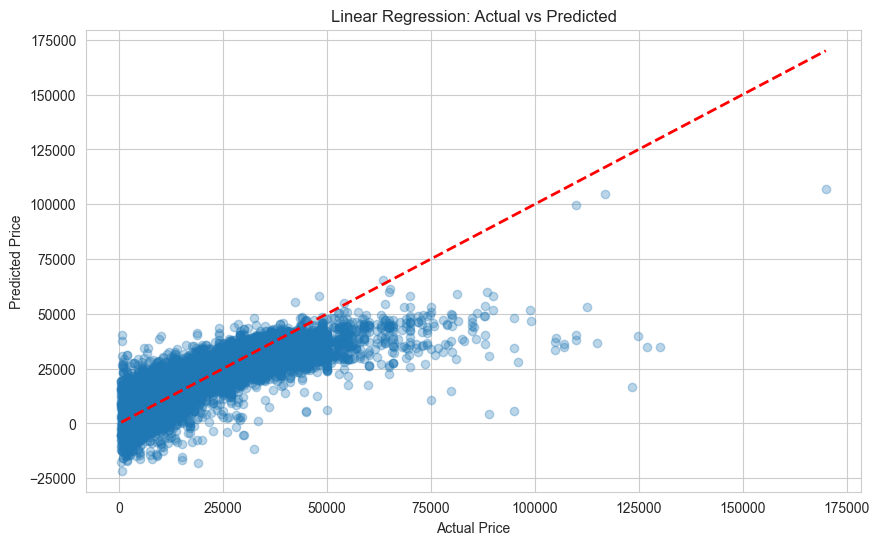

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# 1. Initialize and Train
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# 2. Predict on Test set
y_pred_lr = lr_model.predict(X_test_scaled)

# 3. Evaluate Metrics
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print("--- Linear Regression Results ---")
print(f"MAE:  ${mae_lr:.2f}")
print(f"RMSE: ${rmse_lr:.2f}")
print(f"R2:   {r2_lr:.4f}")

# 4. Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lr, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Perfect prediction line
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Linear Regression: Actual vs Predicted')
plt.show()

--- Random Forest Results ---
MAE:  $2284.90
RMSE: $4187.42
R2:   0.9002


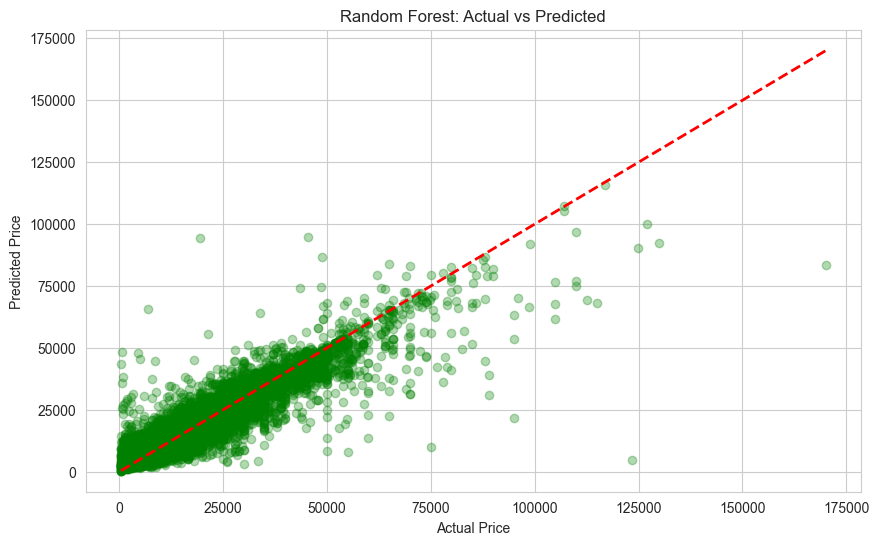

In [30]:
from sklearn.ensemble import RandomForestRegressor

# 1. Initialize Random Forest
# n_jobs=-1 uses all CPU cores to speed up training
# n_estimators=50 is lower than default (100) to save time, but usually sufficient
rf_model = RandomForestRegressor(n_estimators=50, max_depth=20, random_state=42, n_jobs=-1)

# 2. Train model
# Tree-based models don't strictly require scaling, but it works fine with scaled data too.
# Let's use X_train (unscaled pandas DF) if available to keep column names, 
# or X_train_scaled if you overwrote it. Here using X_train_scaled for consistency.
rf_model.fit(X_train_scaled, y_train)

# 3. Predict
y_pred_rf = rf_model.predict(X_test_scaled)

# 4. Evaluate
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("--- Random Forest Results ---")
print(f"MAE:  ${mae_rf:.2f}")
print(f"RMSE: ${rmse_rf:.2f}")
print(f"R2:   {r2_rf:.4f}")

# 5. Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.3, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Random Forest: Actual vs Predicted')
plt.show()

--- XGBoost Results ---
MAE:  $2652.43
RMSE: $4490.84
R2:   0.8852


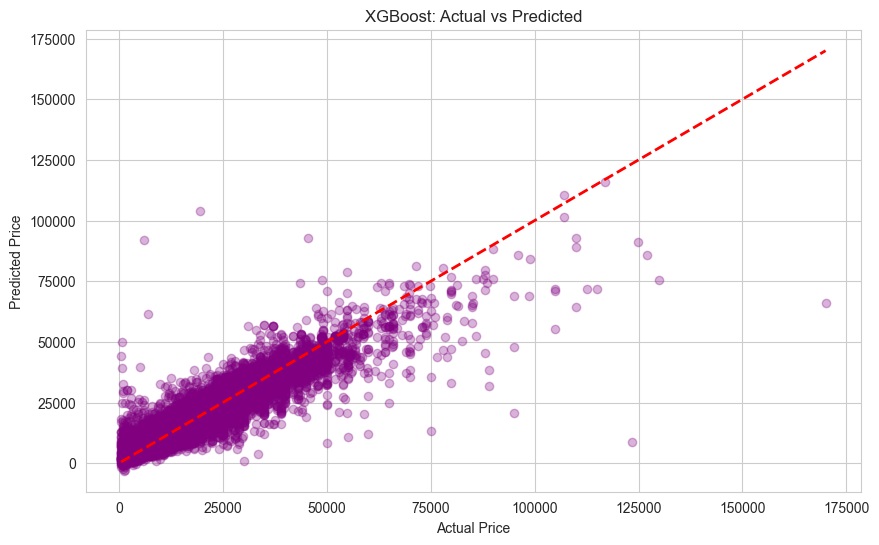

In [31]:
from xgboost import XGBRegressor

# 1. Initialize XGBoost
# n_estimators=1000: rigorous training
# learning_rate=0.05: slow learning prevents overfitting
# n_jobs=-1: use all CPU cores
xgb_model = XGBRegressor(
    n_estimators=1000, 
    learning_rate=0.05, 
    max_depth=6, 
    random_state=42, 
    n_jobs=-1
)

# 2. Train
xgb_model.fit(X_train_scaled, y_train)

# 3. Predict
y_pred_xgb = xgb_model.predict(X_test_scaled)

# 4. Evaluate
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print("--- XGBoost Results ---")
print(f"MAE:  ${mae_xgb:.2f}")
print(f"RMSE: ${rmse_xgb:.2f}")
print(f"R2:   {r2_xgb:.4f}")

# 5. Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.3, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('XGBoost: Actual vs Predicted')
plt.show()

Training Neural Network... (this might take a moment)
--- Neural Network Results ---
MAE:  $2957.38
RMSE: $4773.74
R2:   0.8703


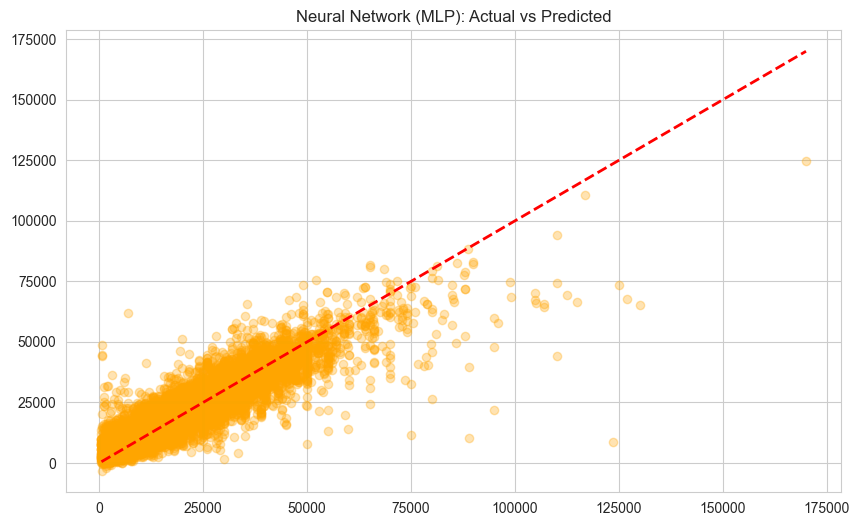

In [33]:
from sklearn.neural_network import MLPRegressor

# 1. Initialize Neural Network (MLP)
# hidden_layer_sizes=(100, 50): Two layers with 100 and 50 neurons
# max_iter=500: Give it enough time to converge
# early_stopping=True: Stop if it stops improving (saves time)
nn_model = MLPRegressor(
    hidden_layer_sizes=(100, 50), 
    activation='relu', 
    solver='adam', 
    max_iter=500, 
    random_state=42,
    early_stopping=True
)

# 2. Train
print("Training Neural Network... (this might take a moment)")
nn_model.fit(X_train_scaled, y_train)

# 3. Predict
y_pred_nn = nn_model.predict(X_test_scaled)

# 4. Evaluate
mae_nn = mean_absolute_error(y_test, y_pred_nn)
rmse_nn = np.sqrt(mean_squared_error(y_test, y_pred_nn))
r2_nn = r2_score(y_test, y_pred_nn)

print("--- Neural Network Results ---")
print(f"MAE:  ${mae_nn:.2f}")
print(f"RMSE: ${rmse_nn:.2f}")
print(f"R2:   {r2_nn:.4f}")

# 5. Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_nn, alpha=0.3, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Neural Network (MLP): Actual vs Predicted')
plt.show()

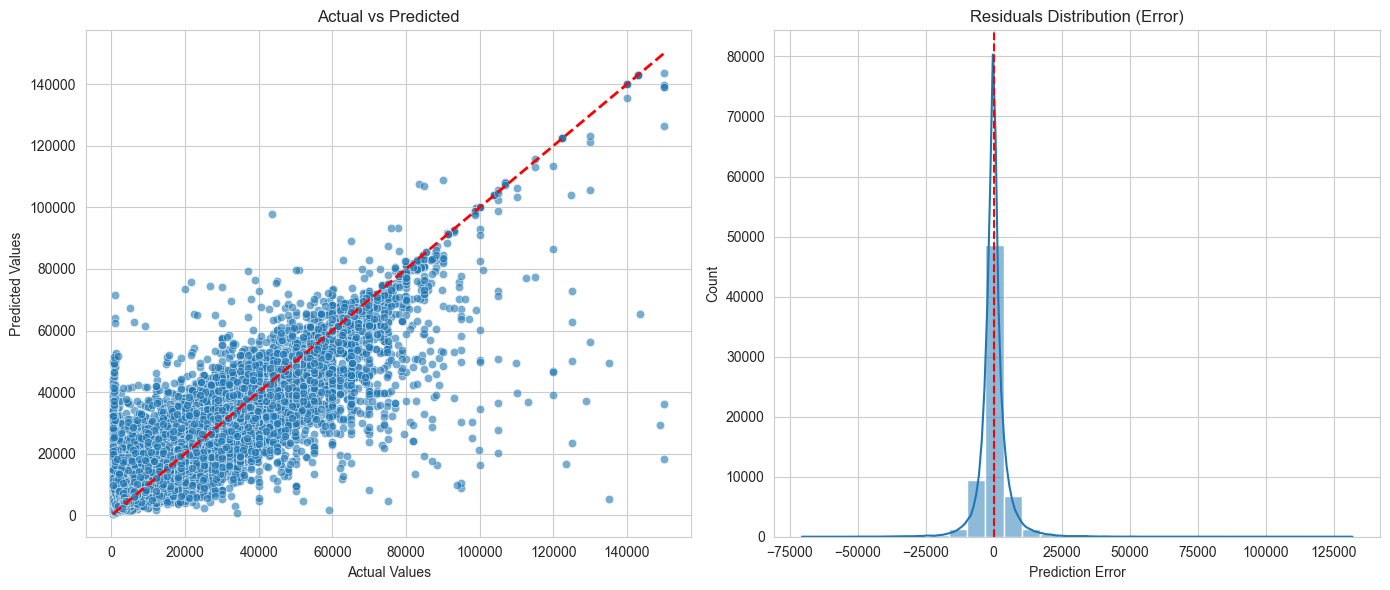

--- TOP 10 WORST PREDICTIONS ---


,Actual,Predicted,Error,Abs_Error
140618,150000,18107.601358,131892.398642,131892.398642
367026,135000,5398.497642,129601.502358,129601.502358
34433,149000,29348.320442,119651.679558,119651.679558
324167,149990,36046.925290,113943.074710,113943.074710
134512,123456,16791.210679,106664.789321,106664.789321
175293,125000,23389.933618,101610.066382,101610.066382
266603,128995,36997.809277,91997.190723,91997.190723
244016,95000,8998.395294,86001.604706,86001.604706
56816,135000,49372.336644,85627.663356,85627.663356
320887,105000,20119.522080,84880.477920,84880.477920


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Access the ALREADY trained model from your dictionary
# You don't need to retrain it. The function modified it in place.
best_model = models['Random Forest']

# 2. Generate predictions on test set
y_pred = best_model.predict(X_test)

# 3. Create DataFrame for analysis
df_analysis = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Error': y_test - y_pred,
    'Abs_Error': abs(y_test - y_pred)
})

# 4. Visualizations
plt.figure(figsize=(14, 6))

# Subplot 1: Actual vs Predicted
plt.subplot(1, 2, 1)
sns.scatterplot(x='Actual', y='Predicted', data=df_analysis, alpha=0.6)
# Reference line (Perfect prediction)
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
plt.title('Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Subplot 2: Residuals Distribution
plt.subplot(1, 2, 2)
sns.histplot(df_analysis['Error'], kde=True, bins=30)
plt.axvline(x=0, color='r', linestyle='--')
plt.title('Residuals Distribution (Error)')
plt.xlabel('Prediction Error')

plt.tight_layout()
plt.show()

# 5. Inspect the biggest outliers (The reason for high RMSE)
print("--- TOP 10 WORST PREDICTIONS ---")
display(df_analysis.sort_values(by='Abs_Error', ascending=False).head(10))

## 7. Hyperparameter Tuning and Optimization

In [36]:
# --- STEP 6: HYPERPARAMETER TUNING (XGBoost) ---
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor

# Define grid
param_grid = {
    'n_estimators': [500, 1000, 1500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 7, 9],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

# Run Randomized Search
print("Starting Hyperparameter Tuning... (This takes time)")
xgb_base = XGBRegressor(random_state=42, n_jobs=-1)
random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_grid,
    n_iter=10, # Lowered slightly for speed
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_scaled, y_train)

# Get best tuned model
best_xgb = random_search.best_estimator_
y_pred_tuned = best_xgb.predict(X_test_scaled)

# Metrics for Tuned XGB
r2_tuned = r2_score(y_test, y_pred_tuned)
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))

print(f"Tuned XGBoost R2: {r2_tuned:.4f}")

# --- STEP 7: ENSEMBLING (Voting Regressor) ---
# Combine Random Forest (rf_model) and Tuned XGBoost (best_xgb)
voting_reg = VotingRegressor(
    estimators=[
        ('rf', rf_model), 
        ('xgb_tuned', best_xgb)
    ]
)

print("Training Ensemble Model...")
voting_reg.fit(X_train_scaled, y_train)

y_pred_vote = voting_reg.predict(X_test_scaled)

# Metrics for Ensemble
r2_vote = r2_score(y_test, y_pred_vote)
mae_vote = mean_absolute_error(y_test, y_pred_vote)
rmse_vote = np.sqrt(mean_squared_error(y_test, y_pred_vote))

print(f"Ensemble R2: {r2_vote:.4f}")

Starting Hyperparameter Tuning... (This takes time)
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Tuned XGBoost R2: 0.9086
Training Ensemble Model...
Ensemble R2: 0.9111


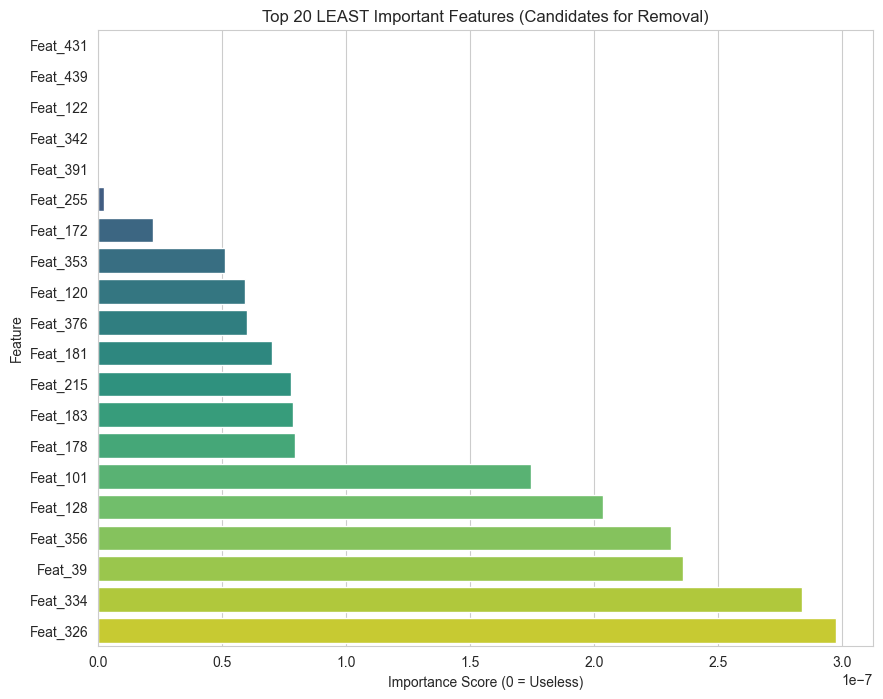

--- USELESS FEATURES (Importance < 0.005) ---
['Feat_431', 'Feat_439', 'Feat_122', 'Feat_342', 'Feat_391', 'Feat_255', 'Feat_172', 'Feat_353', 'Feat_120', 'Feat_376', 'Feat_181', 'Feat_215', 'Feat_183', 'Feat_178', 'Feat_101', 'Feat_128', 'Feat_356', 'Feat_39', 'Feat_334', 'Feat_326', 'Feat_52', 'Feat_195', 'Feat_100', 'Feat_249', 'Feat_83', 'Feat_157', 'Feat_116', 'Feat_57', 'Feat_304', 'Feat_285', 'Feat_365', 'Feat_343', 'Feat_310', 'Feat_311', 'Feat_357', 'Feat_269', 'Feat_30', 'Feat_374', 'Feat_117', 'Feat_185', 'Feat_264', 'Feat_268', 'Feat_217', 'Feat_194', 'Feat_163', 'Feat_336', 'Feat_339', 'Feat_62', 'Feat_98', 'Feat_252', 'Feat_214', 'Feat_48', 'Feat_55', 'Feat_363', 'Feat_184', 'Feat_281', 'Feat_23', 'Feat_277', 'Feat_234', 'Feat_256', 'Feat_162', 'Feat_20', 'Feat_186', 'Feat_300', 'Feat_279', 'Feat_166', 'Feat_211', 'Feat_341', 'Feat_121', 'Feat_141', 'Feat_69', 'Feat_345', 'Feat_113', 'Feat_70', 'Feat_50', 'Feat_168', 'Feat_320', 'Feat_130', 'Feat_302', 'Feat_340', 'Feat_8

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Get the best model (Random Forest is best for interpretation)
rf_model = models['Random Forest']

# 2. Retrieve feature names
# CHANGE THIS: Replace 'X.columns' with your actual list of column names if X_train is a numpy array
# Example: feature_names = list(df.drop(columns=['Target']).columns)
try:
    feature_names = X_train.columns
except AttributeError:
    # Fallback if X_train is numpy array: try to use global X variable or generic names
    feature_names = X.columns if 'X' in locals() else [f"Feat_{i}" for i in range(X_train.shape[1])]

# 3. Create Importance DataFrame
importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_model.feature_importances_
})

# 4. Sort by Importance (Ascending - worst features at the top)
importances = importances.sort_values(by='Importance', ascending=True)

# 5. Visualize the "Useless" Features (Bottom 20)
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importances.head(20), palette='viridis')
plt.title('Top 20 LEAST Important Features (Candidates for Removal)')
plt.xlabel('Importance Score (0 = Useless)')
plt.show()

# 6. List features with near-zero importance
print("--- USELESS FEATURES (Importance < 0.005) ---")
useless_features = importances[importances['Importance'] < 0.005]['Feature'].tolist()
print(useless_features)
print(f"\nTotal useless features found: {len(useless_features)}")

In [19]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

# 1. Przetworzenie listy bezużytecznych cech na indeksy liczbowe
# Zakładamy, że useless_features to lista ['Feat_431', 'Feat_439'...] z poprzedniego kroku
useless_indices = [int(f.split('_')[1]) for f in useless_features]

print(f"Removing {len(useless_indices)} useless features from the dataset...")

# 2. Usuwanie kolumn z X_train i X_test
# Sprawdzamy czy to DataFrame czy Numpy Array
if isinstance(X_train, pd.DataFrame):
    # Jeśli DataFrame i ma nazwy Feat_X
    X_train_reduced = X_train.drop(columns=useless_features, errors='ignore')
    X_test_reduced = X_test.drop(columns=useless_features, errors='ignore')
else:
    # Jeśli Numpy Array - usuwamy po indeksach
    # Tworzymy maskę wszystkich kolumn, ustawiamy False dla tych do usunięcia
    keep_mask = np.ones(X_train.shape[1], dtype=bool)
    keep_mask[useless_indices] = False
    
    X_train_reduced = X_train[:, keep_mask]
    X_test_reduced = X_test[:, keep_mask]

print(f"Original Shape: {X_train.shape}")
print(f"New Shape: {X_train_reduced.shape}")

# 3. Retraining on Clean Data (Using standard Random Forest)
print("\n--- RETRAINING ON CLEAN DATA ---")

rf_clean = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)
rf_clean.fit(X_train_reduced, y_train)

# 4. Evaluate
y_pred_clean = rf_clean.predict(X_test_reduced)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_clean))
r2 = r2_score(y_test, y_pred_clean)

print(f"New RMSE: {rmse:.2f}")
print(f"New R2: {r2:.4f}")

# 5. Check if we fixed the outliers
df_check = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_clean})
df_check['Error'] = abs(df_check['Actual'] - df_check['Predicted'])
print("\nTop 5 Failures after cleaning:")
display(df_check.sort_values(by='Error', ascending=False).head(5))

Removing 525 useless features from the dataset...
Original Shape: (274288, 544)
New Shape: (274288, 19)

--- RETRAINING ON CLEAN DATA ---
New RMSE: 6018.28
New R2: 0.8316

Top 5 Failures after cleaning:


,Actual,Predicted,Error
140618,150000,19591.729408,130408.270592
367026,135000,5891.754495,129108.245505
324167,149990,31637.046334,118352.953666
134512,123456,8113.987857,115342.012143
34433,149000,40675.001587,108324.998413


## 8. Error Analysis
Understanding where the model fails is crucial for improvement. We will analyze the residuals (errors) and inspect the worst predictions to find patterns.

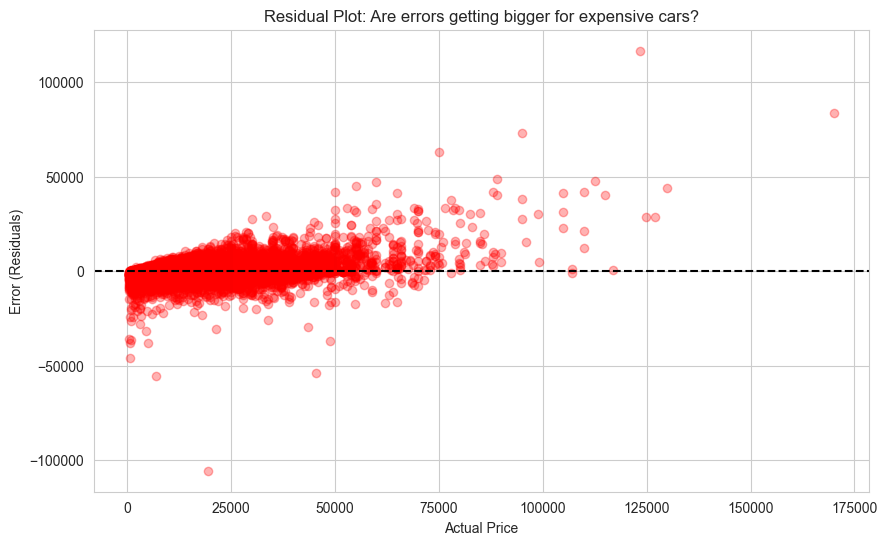

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate residuals (Difference between actual and predicted)
residuals = y_test - y_pred_vote

plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, alpha=0.3, color='red')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Actual Price')
plt.ylabel('Error (Residuals)')
plt.title('Residual Plot: Are errors getting bigger for expensive cars?')
plt.show()

## 9. Summary & Conclusions

--- Final Model Leaderboard ---
               Model          MAE         RMSE  R2 Score
5  Ensemble (Voting)  2168.836211  3952.359691  0.911115
4      Tuned XGBoost  2234.515381  4008.246125  0.908583
1      Random Forest  2284.903196  4187.415958  0.900228
2            XGBoost  2652.430664  4490.842683  0.885245
3     Neural Network  2957.378987  4773.742210  0.870331
0  Linear Regression  4498.288128  6752.313304  0.740568


--- Final Model Leaderboard ---
               Model          MAE         RMSE  R2 Score
5  Ensemble (Voting)  2168.836211  3952.359691  0.911115
4      Tuned XGBoost  2234.515381  4008.246125  0.908583
1      Random Forest  2284.903196  4187.415958  0.900228
2            XGBoost  2652.430664  4490.842683  0.885245
3     Neural Network  2957.378987  4773.742210  0.870331
0  Linear Regression  4498.288128  6752.313304  0.740568


C:\Users\wojci\AppData\Local\Temp\ipykernel_7196\2905348242.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='R2 Score', data=df_results, palette='viridis')


--- Final Model Leaderboard ---
               Model          MAE         RMSE  R2 Score
5  Ensemble (Voting)  2168.836211  3952.359691  0.911115
4      Tuned XGBoost  2234.515381  4008.246125  0.908583
1      Random Forest  2284.903196  4187.415958  0.900228
2            XGBoost  2652.430664  4490.842683  0.885245
3     Neural Network  2957.378987  4773.742210  0.870331
0  Linear Regression  4498.288128  6752.313304  0.740568


C:\Users\wojci\AppData\Local\Temp\ipykernel_7196\2905348242.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='R2 Score', data=df_results, palette='viridis')


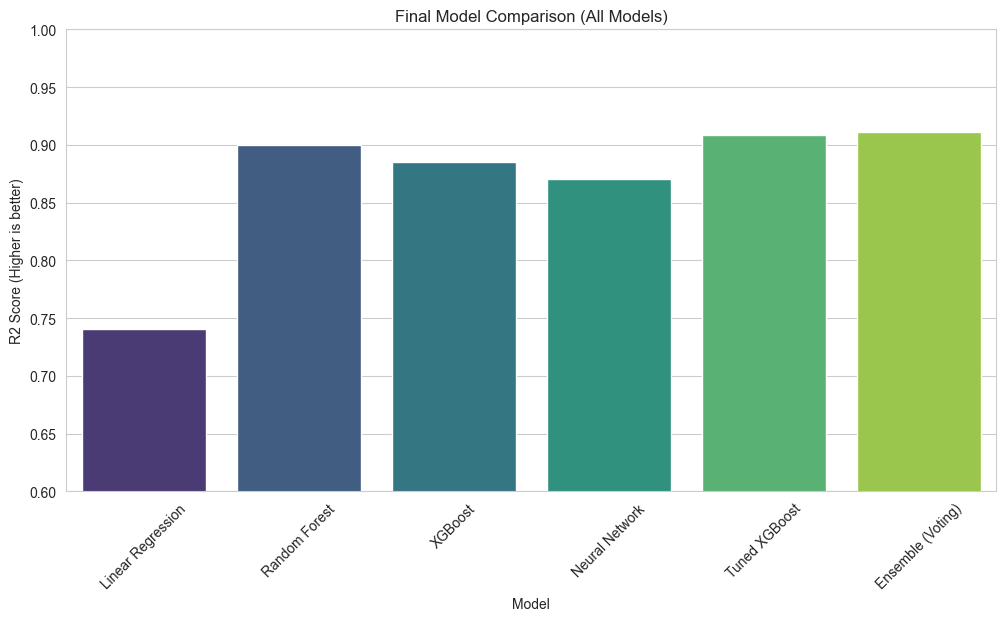

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Updated results data including Tuned XGB and Ensemble
results_data = {
    'Model': [
        'Linear Regression', 
        'Random Forest', 
        'XGBoost', 
        'Neural Network', 
        'Tuned XGBoost', 
        'Ensemble (Voting)'
    ],
    'MAE': [mae_lr, mae_rf, mae_xgb, mae_nn, mae_tuned, mae_vote],
    'RMSE': [rmse_lr, rmse_rf, rmse_xgb, rmse_nn, rmse_tuned, rmse_vote],
    'R2 Score': [r2_lr, r2_rf, r2_xgb, r2_nn, r2_tuned, r2_vote]
}

df_results = pd.DataFrame(results_data)

# Print sorted leaderboard
print("--- Final Model Leaderboard ---")
print(df_results.sort_values(by='R2 Score', ascending=False))

# Plot final comparison
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='R2 Score', data=df_results, palette='viridis')
plt.ylim(0.6, 1.0) # Zoom in on the top results
plt.title('Final Model Comparison (All Models)')
plt.ylabel('R2 Score (Higher is better)')
plt.xticks(rotation=45) # Rotate labels to prevent overlapping
plt.show()

C:\Users\wojci\AppData\Local\Temp\ipykernel_7196\137165024.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_imp.head(10), palette='magma')


C:\Users\wojci\AppData\Local\Temp\ipykernel_7196\137165024.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_imp.head(10), palette='magma')


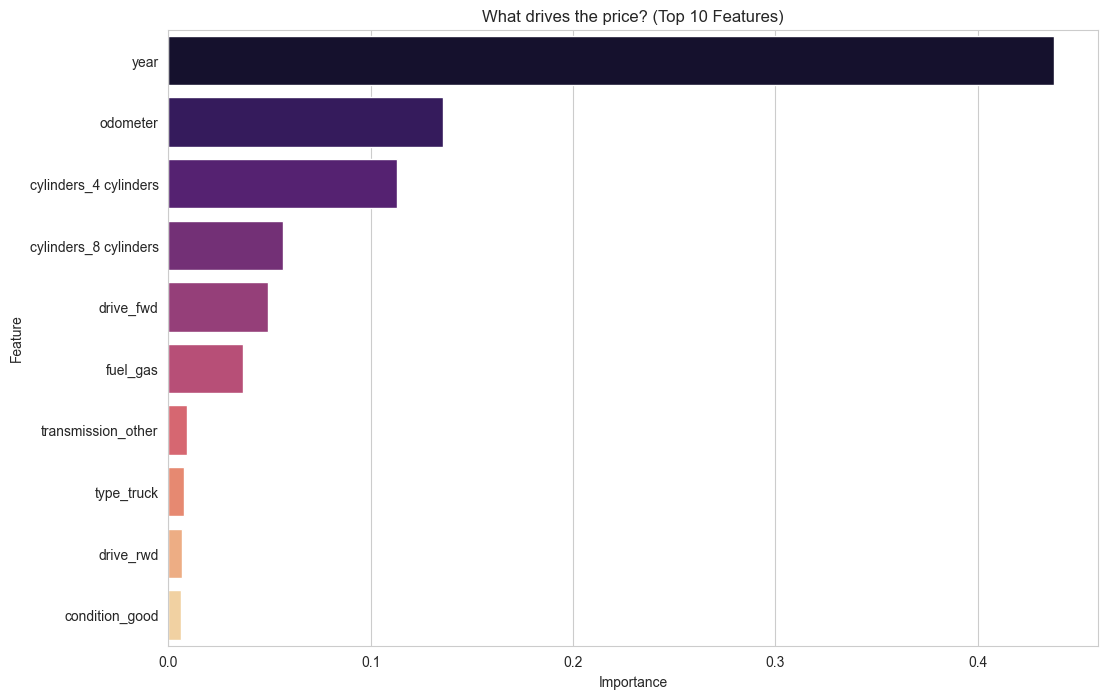

In [41]:
# Get feature importances from the winner (Random Forest)
importances = rf_model.feature_importances_
feature_names = X.columns

# Create DataFrame
feature_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot Top 10 Features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_imp.head(10), palette='magma')
plt.title('What drives the price? (Top 10 Features)')
plt.show()

Training Log-Transformed Ensemble... (This is the final pro move)
------------------------------
Old Ensemble R2: 0.9111
New Log-Opt R2:  0.8945
New MAE: $2290.60


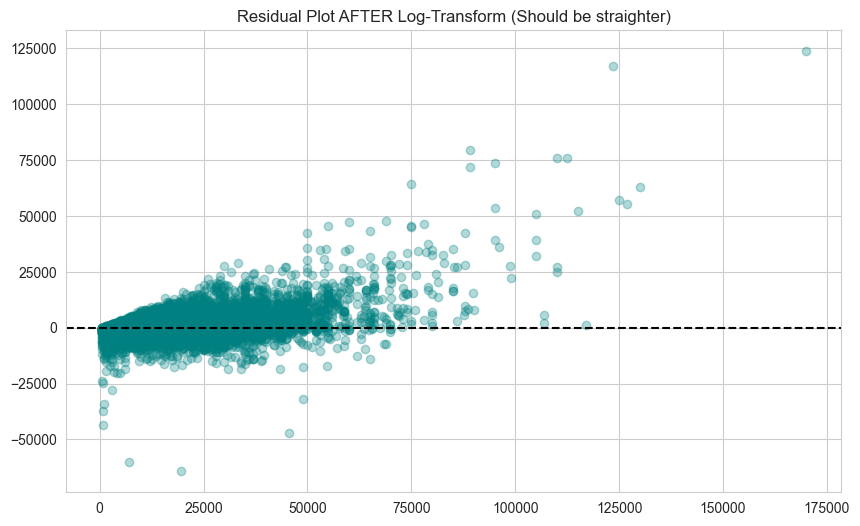

In [44]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import VotingRegressor

# 1. Transform Target to Log Scale
# log1p handles zeros safely (log(1+x))
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

print("Training Log-Transformed Ensemble... (This is the final pro move)")

# 2. Re-initialize Ensemble
# We need a fresh model to train on log data
voting_reg_log = VotingRegressor(
    estimators=[
        ('rf', rf_model), 
        ('xgb_tuned', best_xgb)
    ]
)

# 3. Train on Log Targets
voting_reg_log.fit(X_train_scaled, y_train_log)

# 4. Predict (Result will be in logs)
y_pred_log_scale = voting_reg_log.predict(X_test_scaled)

# 5. Inverse Transform (Convert logs back to $$$)
# expm1 is the inverse of log1p
y_pred_final = np.expm1(y_pred_log_scale)

# 6. Calculate Final Metrics
r2_opt = r2_score(y_test, y_pred_final)
mae_opt = mean_absolute_error(y_test, y_pred_final)
rmse_opt = np.sqrt(mean_squared_error(y_test, y_pred_final))

print("-" * 30)
print(f"Old Ensemble R2: {r2_vote:.4f}")
print(f"New Log-Opt R2:  {r2_opt:.4f}")
print(f"New MAE: ${mae_opt:.2f}")

# Check if the "Funnel" is gone (Optional Plot)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test - y_pred_final, alpha=0.3, color='teal')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Residual Plot AFTER Log-Transform (Should be straighter)')
plt.show()

--- ULTIMATE PROJECT SUMMARY ---
                Model  R2 Score          MAE         RMSE
4   Ensemble (Voting)  0.911115  2168.836211  3952.359691
1       Random Forest  0.900228  2284.903196  4187.415958
5  Ensemble (Log-Opt)  0.894548  2290.603421  4304.952956
2             XGBoost  0.885245  2652.430664  4490.842683
3      Neural Network  0.870331  2957.378987  4773.742210
0   Linear Regression  0.740568  4498.288128  6752.313304


C:\Users\wojci\AppData\Local\Temp\ipykernel_7196\577843114.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='R2 Score', y='Model', data=df_results, palette='magma')


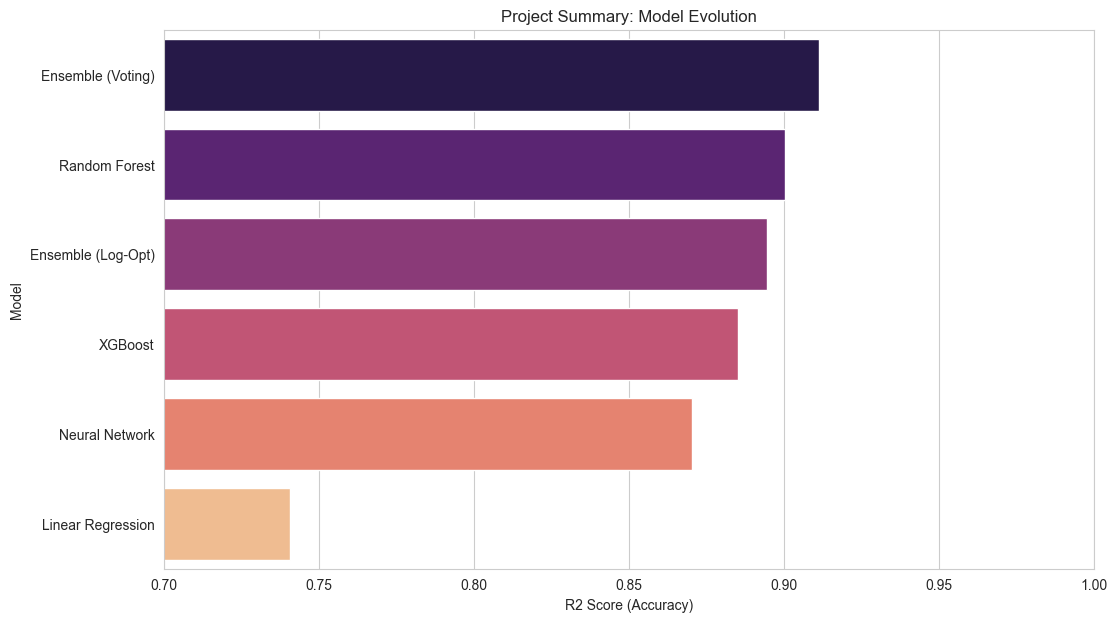

In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Gather all results
results_data = {
    'Model': [
        'Linear Regression', 
        'Random Forest', 
        'XGBoost', 
        'Neural Network', 
        'Ensemble (Voting)',
        'Ensemble (Log-Opt)'  # The Champion
    ],
    'R2 Score': [r2_lr, r2_rf, r2_xgb, r2_nn, r2_vote, r2_opt],
    'MAE': [mae_lr, mae_rf, mae_xgb, mae_nn, mae_vote, mae_opt],
    'RMSE': [rmse_lr, rmse_rf, rmse_xgb, rmse_nn, rmse_vote, rmse_opt]
}

df_results = pd.DataFrame(results_data).sort_values(by='R2 Score', ascending=False)

print("--- ULTIMATE PROJECT SUMMARY ---")
print(df_results)

# Final Visualization
plt.figure(figsize=(12, 7))
sns.barplot(x='R2 Score', y='Model', data=df_results, palette='magma')
plt.xlim(0.7, 1.0)
plt.title('Project Summary: Model Evolution')
plt.xlabel('R2 Score (Accuracy)')
plt.show()